# Ürünlerin genel olarak olumlu olumsuz tahminlemesini gerçekleştirmeden önce, veri seti üzerinde metinsel veri analizinin gerçekleştirilmesini kapsamaktadır.

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkishreviews/hb.csv
/kaggle/input/stopwords/stopwords.csv


# Veri Ön İşleme

In [2]:
#import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import math
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob


In [3]:
pip install textstat

     |████████████████████████████████| 99 kB 793 kB/s 
     |████████████████████████████████| 1.9 MB 3.3 MB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import textstat

In [5]:
# load dataset

text=pd.read_csv('/kaggle/input/turkishreviews/hb.csv')
text.shape
text["Rating"] = -1

In [6]:
text.head()

,Rating (Star),Review,URL,Rating
0,5,3 yıldır tık demedi. :),https://www.hepsiburada.com/logitech-m175-kabl...,-1
1,5,3 yıldır kullanıyorum müthiş,https://www.hepsiburada.com/logitech-m175-kabl...,-1
2,4,Ürün bugün elime geçti çok fazla inceleme fırs...,https://www.hepsiburada.com/logitech-m175-kabl...,-1
3,4,Almaya karar verdim. Hemencecik geldi. Keyifle...,https://www.hepsiburada.com/logitech-m175-kabl...,-1
4,5,Günlük kullanımınızı çok çok iyi karsılıyor kı...,https://www.hepsiburada.com/logitech-m175-kabl...,-1


In [7]:
#Select required features for analysis from the 4 given columns.

text.columns

Index(['Rating (Star)', 'Review', 'URL', 'Rating'], dtype='object')

In [8]:
#Select the the 4 key columns, product url, review content, users if they recommend the product
textdata = text[['URL','Review','Rating','Rating (Star)']]
textdata.head()

,URL,Review,Rating,Rating (Star)
0,https://www.hepsiburada.com/logitech-m175-kabl...,3 yıldır tık demedi. :),-1,5
1,https://www.hepsiburada.com/logitech-m175-kabl...,3 yıldır kullanıyorum müthiş,-1,5
2,https://www.hepsiburada.com/logitech-m175-kabl...,Ürün bugün elime geçti çok fazla inceleme fırs...,-1,4
3,https://www.hepsiburada.com/logitech-m175-kabl...,Almaya karar verdim. Hemencecik geldi. Keyifle...,-1,4
4,https://www.hepsiburada.com/logitech-m175-kabl...,Günlük kullanımınızı çok çok iyi karsılıyor kı...,-1,5


In [9]:
#Drop null values
textdata.dropna(inplace=True)
textdata.isna().sum()

URL              0
Review           0
Rating           0
Rating (Star)    0
dtype: int64

In [10]:
textcopy=textdata.copy()


In [11]:
#Filter products based on number of reviews

textdata=textdata.groupby(['URL']).filter(lambda x: len(x)>300).reset_index(drop=True)
print('Number of products matching the criteria is ',len(textdata['URL'].unique()))

Number of products matching the criteria is  214


In [12]:
#convert datatype boolean and float to int
textdata['Rating']=textdata['Rating (Star)'].astype(int)

In [13]:


textdata['URL'].unique()
textdata['URL']=textdata['URL'].apply(lambda x: x.split(',,,')[0])

In [14]:
#Explore and clean the review text

for text in enumerate(textdata['Review'][20:30]):
  print('Review:\n',text)

Review:
 (0, 'Ürün süper kalitede değil, malzeme açısından ama fiyatı belli. İş görüyor. Birçok yüzeyde rahatlıkla kullanılabiliyor.')
Review:
 (1, 'sağlam ve dayanıklı bir ürün herkese tavsiye edebilirim ilk ürünü 2013 yılında almıştım hala kullanmaktayım memnun kaldığım için yenilerini sipariş verdim .')
Review:
 (2, 'fiyatına göre ortalama bi mause. Oyun için alıyorsanız denemeyin. Standart kullanım için yeterli ama benim orta teker bozuldu onun dışında iyi ..')
Review:
 (3, 'Çok iyi')
Review:
 (4, 'Ürün gayet güzel Kısa surede elime geçti teşekkürler')
Review:
 (5, 'Ürünü almadan önce yorumları okuduğumda çok kısa sürede geldiği yazıyordu. Fiyatı da uygun olunca sipariş verdim. Ürün gayet şık ve kullanışlı. Özellikle eli küçük olanlar için gayet pratik. Tek eksi yönü dört günde gelmesi:) Düşünenlere tavsiye ederim?? ')
Review:
 (6, "Ürün bir günde elime geçti. Hepsiburada'ya teşekkür ederim. Oaketinden çıkardıktan sonra hemen kullanmaya başladım. Çok memnunum, tavsiye ederim.")
Rev

In [15]:
# While developing NLP models capital and lowercase letters are treated differently so its required to convert all words to lowercase, as few words are in capitals in the review text.

textdata['Review']=textdata['Review'].apply(lambda x: x.lower())

In [16]:
# Eliminate digits in the text using regular expressions

textdata['Review']=textdata['Review'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [17]:
#Eliminate punctuaitons

textdata['Review']=textdata['Review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

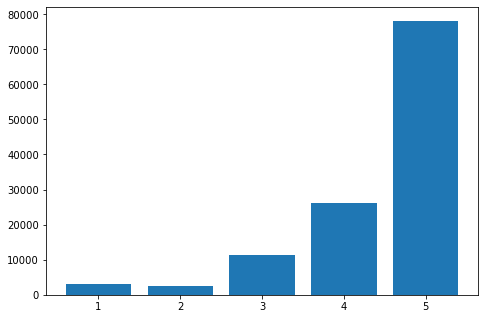

In [18]:
product_review_count=textdata.groupby(['Rating']).agg(['mean', 'count'])
product_review_count.head()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(product_review_count["Rating (Star)"]["mean"], product_review_count["Rating (Star)"]["count"])
plt.show()

**Yukarıda gördüğümüz grafikte yüksek oy verenlerin daha fazla yorum yaptığı gözlemlenmiştir. Hipotez olarak; olumlu oy verenlerin sistem içerisinde fazla yorum yapmaya dahil olduğunu söyleyebiliriz.**

**SpaCy yorumlarda yer alan en çok kelimeleri tespit etmek için kullanılmaktadır. **

In [19]:
!python -m spacy download xx_ent_wiki_sm
!python -m spacy link xx_ent_wiki_sm xx_model

     |████████████████████████████████| 3.7 MB 413 kB/s 
  Created wheel for xx-ent-wiki-sm: filename=xx_ent_wiki_sm-2.3.0-py3-none-any.whl size=3741309 sha256=f7a7e89d1d5272b81772bafa18adb32320df0941234f8d34a7230df656aeda28
  Stored in directory: /tmp/pip-ephem-wheel-cache-fepzmv9l/wheels/6d/3a/e2/6f3c30d9b864273b5c88e6cf82e83bdafff5296cd949915598
Successfully built xx-ent-wiki-sm
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('xx_ent_wiki_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/xx_ent_wiki_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/xx_model
You can now load the model via spacy.load('xx_model')


In [20]:
# use spacy module
from spacy.lang.tr import Turkish
nlp = Turkish()
nlp.max_length = 199386400

stop_word_list=pd.read_csv('/kaggle/input/stopwords/stopwords.csv')
print(stop_word_list)

spacy_stopwords = spacy.lang.tr.stop_words.STOP_WORDS

for w in stop_word_list['Words']:
    spacy_stopwords.add(w)
  
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:10])

text = "Pekala, bu nedenle süper bir ürün."
doc = nlp(text)
tokens = [token.text for token in doc if not token.is_stop]

print('Original Article: %s' % (text))
print()
print(tokens)
#tokens_without_sw= [word for word in text_tokens if not word in all_stopwords]

#print(tokens_without_sw)

      Words
0     acaba
1       ama
2   aslında
3        az
4      bazı
5     belki
6       bir
7      biri
8    birkaç
9    birşey
10    bişey
11      biz
12       bu
13      çok
14    çünkü
15       da
16     daha
17       de
18     defa
19     diye
20     eğer
21       en
22     gibi
23      hem
24      hep
25    hepsi
26      her
27      hiç
28     için
29      ile
30      ise
31      kez
32       ki
33      kim
34       mi
35       mu
36       mü
37    nasıl
38       ne
39    neden
40   nerede
41    niçin
42     niye
43        o
44    sanki
45      şey
46      siz
47       şu
48      tüm
49       ve
50     veya
51       ya
52     yani
53     ürün
54    ürünü
55       bi
56   ederim
57    aldım
Number of stop words: 558
First ten stop words: ['burada', 'defa', 'de', 'ben', 'gayrı', 'yaptıkları', 'nereye', 'henüz', 'netekim', 'hiçbir']
Original Article: Pekala, bu nedenle süper bir ürün.

[',', 'süper', '.']


In [21]:

# stopwords removal and lemmatization
textdata['Review']=textdata['Review'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

textdata=textdata[['Rating (Star)','Review']].groupby(by='Rating (Star)').agg(lambda x:' '.join(x))
textdata.head()

,Review
Rating (Star),
1,mausum tıklama tutukluk aynı noktaya tıklamam ...
2,fiyatına ortalama mause oyun alıyorsanız denem...
3,evde oyuncu faresi kullanmaya alışkın olduğumd...
4,bugün elime geçti fazla inceleme fırsatım olma...
5,yıldır tık demedi yıldır kullanıyorum müth...


In [22]:
#Generate document term matrix to find most occuring terms in the reviews

cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(textdata['Review'])
text_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
text_dtm.index=textdata.index
text_dtm.head()

,aa,aaa,aaaa,aaaaa,aaaaaal,aaat,aac,aacaba,aacımda,aacımın,...,şıuk,şıyor,şıçrıyor,şığında,şşallah,şşeyi,şşimdi,şşimdiye,şşiriyor,şşşşşşşş
Rating (Star),,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,3,5,11,7,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,3,3,0,0,0,1,0,0,1,0,...,0,1,1,1,0,0,1,0,0,0
5,7,3,1,0,1,0,1,1,0,0,...,0,0,0,0,1,0,0,1,1,1


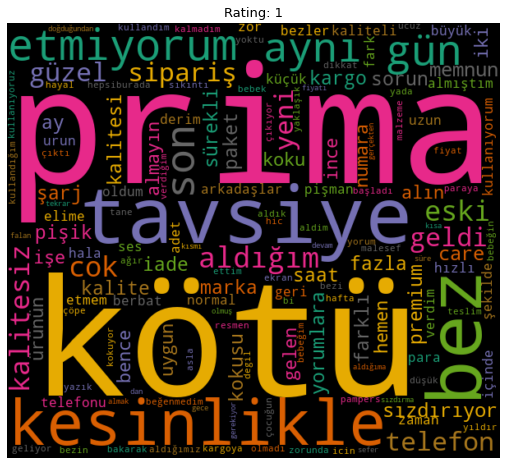

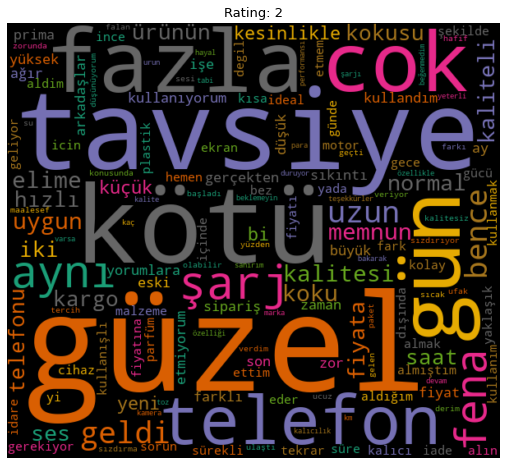

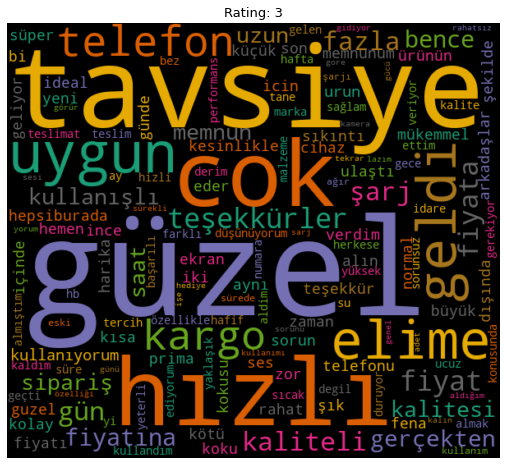

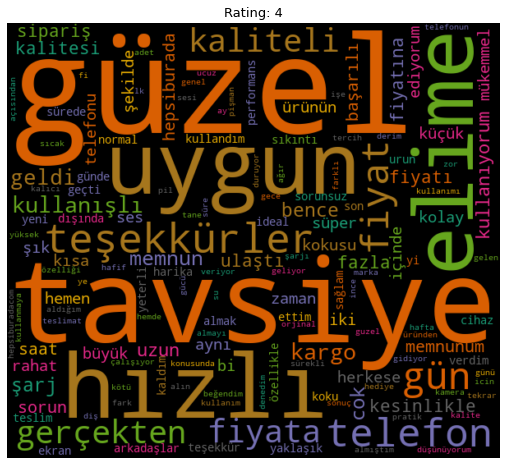

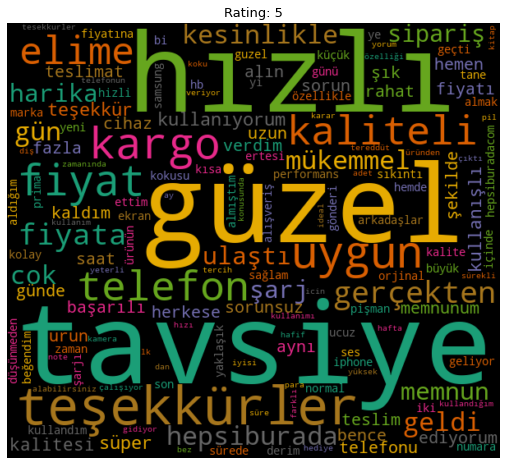

In [23]:
def wordcloud(data,title):
  title = str(title)
  wc = WordCloud(width=600, height=530, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title(('Rating: ' + title),fontsize=13)
  plt.show()
  
text_dtm=text_dtm.transpose()

for index,product in enumerate(text_dtm.columns):
  wordcloud(text_dtm[product].sort_values(ascending=False),product)
 


**Kelime bulutu, incelemelerde en sık görülen terimleri hızlı bir şekilde anlamanıza ve görselleştirmenize yardımcı olmaktadır.

In [24]:
#Polarity in sentiment analysis refers to identifying sentiment orientation (positive, neutral, and negative) in written or spoken language.

textdata['emotion']=textdata['Review'].apply(lambda x:TextBlob(x).sentiment.polarity)

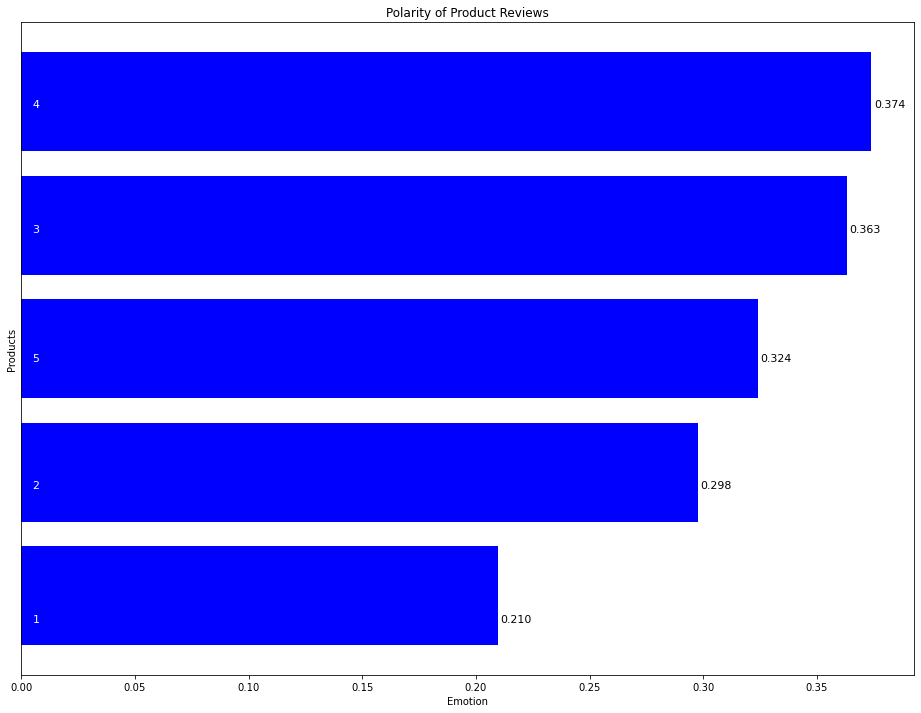

In [25]:
product_polarity=pd.DataFrame(textdata.groupby('Rating (Star)')['emotion'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,12))
plt.xlabel('Emotion')
plt.ylabel('Products')
plt.title('Polarity of Product Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity.index)),product_polarity['emotion'],color='blue')


for bar,product in zip(polarity_graph,product_polarity.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

for bar,polarity in zip(polarity_graph,product_polarity['emotion']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()